In [2]:
import tensorflow as tf
import scipy
import matplotlib.pyplot as plt
import os
from keras.layers import Conv2D,Rescaling,RandomFlip,RandomRotation,Dense,Flatten,MaxPooling2D,InputLayer,Dropout,RandomZoom,RandomBrightness,RandomTranslation,LeakyReLU,Conv2DTranspose,BatchNormalization,Reshape,Embedding,Concatenate,Input
from keras.losses import SparseCategoricalCrossentropy,BinaryCrossentropy
from keras.utils import plot_model
from keras import Sequential
from keras.optimizers import Adam,SGD,RMSprop
from pathlib import Path
import numpy as np
import copy
from random import randint
import keras
import time
import math

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
rescale = Rescaling(scale=1.0/255,name='rescale')
rotate = RandomRotation(factor=0.4,name="rotate")
flip = RandomFlip(mode="horizontal_and_vertical",name="flip")
zoom = RandomZoom(height_factor=(-0.2, -0.2), name="zoom")
preprocess = lambda x,y: ((x-127.5)/127.5 ,y)
display_model = lambda x: plot_model(x,show_shapes=True)

In [5]:
no_of_class = 102
IMG_SIZE = (120,120)
BATCH = 24

train = tf.keras.utils.image_dataset_from_directory('../102_flowers_dataset/train/',image_size=IMG_SIZE,shuffle=True,batch_size=BATCH)
test = tf.keras.utils.image_dataset_from_directory('../102_flowers_dataset/valid/',image_size=IMG_SIZE,shuffle=True,batch_size=BATCH)

train = train.map(preprocess)
test = test.map(preprocess)

Found 6552 files belonging to 102 classes.
Found 818 files belonging to 102 classes.


2024-09-29 19:43:34.746207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


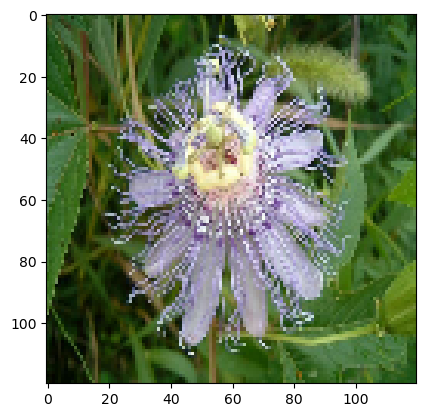

In [7]:
# sampling

for i,j in train.take(1):
    plt.imshow((i[0].numpy()+1)/2.0)

In [196]:
def discriminator_block(filters:int,name:int,input:keras.Layer) -> keras.Layer:
    
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=2, padding='same', name=f'Convo_{name}')(input)
    x = LeakyReLU(name=f'Leaky_{name}')(x)
    x = Dropout(0.1,name=f'Dropout_{name}')(x)
    
    return x
    
def dense_block(filters:list,input: keras.Layer) -> keras.Layer:
    
    x = Dense(filters[0],name=f'Dense_{1}',activation='relu')(input)
    
    for i,j in enumerate(filters[1:]):
        x = Dense(j,name=f'Dense_{i+2}',activation='relu')(x)
    
    return x
    
def make_discriminator_cond(img: tuple[int],no_of_class:int) -> keras.Model:
    label_input = Input(shape=(1,),name='label_input')
    
    l = Embedding(no_of_class,256,name='label_embedding')(label_input)
    l = Dense(np.prod(img),name='label_dense')(l)
    l = Reshape((img[0], img[1],1),name='label_Reshape')(l)
    
    img_input = Input(shape=(img[0],img[1],3),name='image_input')

    
    merge = Concatenate(name='concatenate')([img_input,l])
    
    x = discriminator_block(64,1,merge)
    x = discriminator_block(128,2,x)
    x = discriminator_block(256,3,x)
    x = Flatten(name='flatten')(x)
    
    x = dense_block([128,64,32,16,8],x)

    x = Dense(1, activation='sigmoid', name='final')(x)
    
    discriminator = tf.keras.Model([img_input,label_input],x,name='Conditional_Discriminator')
    
    return discriminator


In [197]:
make_discriminator_cond(IMG_SIZE,no_of_class).summary()

Model: "Conditional_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 256)    │     26,112 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 14400)  │  3,700,800 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_Reshape       │ (None, 120, 120,  │          0 │ label_dense[0][0] │
│ (Reshape)           │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 120, 120,  │          0 │ image_input[0][0… │
│ (Concatenate)       │ 4)                │            │ label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_1 (Conv2D)    │ (None, 60, 60,    │      2,368 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_1 (LeakyReLU) │ (None, 60, 60,    │          0 │ Convo_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1 (Dropout) │ (None, 60, 60,    │          0 │ Leaky_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_2 (Conv2D)    │ (None, 30, 30,    │     73,856 │ Dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_2 (LeakyReLU) │ (None, 30, 30,    │          0 │ Convo_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_2 (Dropout) │ (None, 30, 30,    │          0 │ Leaky_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_3 (Conv2D)    │ (None, 15, 15,    │    295,168 │ Dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_3 (LeakyReLU) │ (None, 15, 15,    │          0 │ Convo_3[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_3 (Dropout) │ (None, 15, 15,    │          0 │ Leaky_3[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 57600)     │          0 │ Dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_1 (Dense)     │ (None, 128)       │  7,372,928 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_2 (Dense)     │ (None, 64)        │      8,256 │ Dense_1[0][0]   

 Total params: 11,482,241 (43.80 MB)

 Trainable params: 11,482,241 (43.80 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#display_model(make_discriminator_cond(IMG_SIZE,no_of_class))

In [10]:
def prime_factors(n:int) -> list:
    result = []
    
    for i in range(2,n//2+1):
        while n%i==0:
            n=n//i
            result.append(i)   

    return result

prime_factors(IMG_SIZE[0])

[2, 2, 2, 3, 5]

In [198]:
latent_dim = np.array([5,5,512])
noise_shape = 128

def upsample_block(filters:int,name:int,strides:int,kernel:int,input:keras.Layer) -> keras.Layer:
    
    x = Conv2DTranspose(filters,(kernel,kernel),strides=strides,padding='same', name=f'conv_{name}')(input)
    x = BatchNormalization(name=f'norm_{name}')(x)
    x = LeakyReLU(name=f'leaky_{name}')(x)
    
    return x

def make_generator_cond(no_of_class:int,noise_shape:tuple[int],latent_dim:tuple[int]) -> keras.Model:
    
    label_input = Input(shape=(1,),name='label_input')
    l = Embedding(no_of_class,100,name='label_embedding')(label_input)
    l = Dense(np.cumprod(latent_dim)[-2],name='label_dense')(l)
    l = Reshape(np.append(latent_dim[:-1],[1]),name='label_Reshape')(l)
    
    noise_input = Input(shape=(noise_shape,),name='noise_input')
    n = Dense(np.prod(latent_dim),name='noise_dense')(noise_input)
    n = BatchNormalization(name='norm_noise')(n)
    n = LeakyReLU(name='leaky_noise')(n)
    n = Reshape(latent_dim,name='noise_reshape')(n)
    
    merge = Concatenate(name='concatenate')([n,l])
    
    x = upsample_block(filters=512,name=1,strides=2,kernel=3,input=merge)
    x = upsample_block(filters=256,name=2,strides=1,kernel=2,input=x)
    
    x = upsample_block(filters=256,name=3,strides=2,kernel=3,input=x)
    x = upsample_block(filters=256,name=4,strides=1,kernel=2,input=x)
    
    x = upsample_block(filters=128,name=5,strides=2,kernel=3,input=x)
    x = upsample_block(filters=128,name=6,strides=1,kernel=2,input=x)

    x = upsample_block(filters=64,name=7,strides=3,kernel=4,input=x)
    x = upsample_block(filters=64,name=8,strides=1,kernel=2,input=x)
    
    x = Conv2DTranspose(3,(3,3),strides=1,padding='same', name='final',activation='tanh')(x)
    
    generator = tf.keras.Model([noise_input,label_input],x,name='Conditional_Generator')
    
    return generator

In [189]:
make_generator_cond(no_of_class,noise_shape,latent_dim).summary()

Model: "Conditional_Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noise_input         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_dense (Dense) │ (None, 12800)     │  1,651,200 │ noise_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_noise          │ (None, 12800)     │     51,200 │ noise_dense[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 256)    │     26,112 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_noise         │ (None, 12800)     │          0 │ norm_noise[0][0]  │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 25)     │      6,425 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_reshape       │ (None, 5, 5, 512) │          0 │ leaky_noise[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_Reshape       │ (None, 5, 5, 1)   │          0 │ label_dense[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 5, 513) │          0 │ noise_reshape[0]… │
│ (Concatenate)       │                   │            │ label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1              │ (None, 10, 10,    │  2,364,416 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_1 (LeakyReLU) │ (None, 10, 10,    │          0 │ conv_1[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2              │ (None, 10, 10,    │  1,049,088 │ leaky_1[0][0]     │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_2 (LeakyReLU) │ (None, 10, 10,    │          0 │ conv_2[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3              │ (None, 20, 20,    │  1,179,904 │ leaky_2[0][0]     │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_3 (LeakyReLU) │ (None, 20, 20,    │          0 │ conv_3[0][0]      │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4              │ (None, 20, 20,    │    262,400 │ leaky_3[0][0]     │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,100,764 (27.09 MB)

 Trainable params: 7,075,164 (26.99 MB)

 Non-trainable params: 25,600 (100.00 KB)

In [11]:
#display_model(make_generator_cond(no_of_class,noise_shape,latent_dim))

In [162]:
class GAN(tf.keras.Model):
    def __init__(self, latent_dim:np.ndarray,noise_shape:int,img_shape:tuple[int]) -> None:
        super(GAN,self).__init__()
        self.latent_shape = latent_dim
        self.noise_shape = noise_shape
        self.img = img_shape
        self.generator = make_generator_cond(no_of_class,self.noise_shape,self.latent_shape)
        self.discriminator = make_discriminator_cond(self.img,no_of_class)
        self.gen_loss = tf.keras.metrics.Mean(name="generator_loss")
        self.dis_loss = tf.keras.metrics.Mean(name="discriminator_loss")
        
    @property
    def metrics(self):
        return [self.gen_loss,self.dis_loss]
    
    def compile(self,gen_opt,dis_opt,gen_loss_func,dis_loss_func):
        super(GAN,self).compile()
        self.gen_opt = gen_opt
        self.dis_opt = dis_opt
        self.gen_loss_func = gen_loss_func
        self.dis_loss_func = dis_loss_func
        
    def call(self,noise,label):
        gen_img = self.generator([noise,label])
        return gen_img
    
    @tf.function
    def train_step(self, image):
        noise=  tf.random.normal([BATCH, self.noise_shape])
        img, label = image
        
        label = tf.expand_dims(label,axis=-1)
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated = self.generator([noise,label],training=True)
        
            real = self.discriminator([img,label],training=True)
            fake = self.discriminator([generated,label],training=True)
            gen_loss_ =  self.gen_loss_func(fake)
            dis_loss_ = self.dis_loss_func(real,fake)
        
        gradients_g = gen_tape.gradient(gen_loss_, self.generator.trainable_variables)
        gradients_d = disc_tape.gradient(dis_loss_, self.discriminator.trainable_variables)

        self.gen_opt.apply_gradients(zip(gradients_g, self.generator.trainable_variables))
        self.dis_opt.apply_gradients(zip(gradients_d, self.discriminator.trainable_variables))

        self.gen_loss.update_state(gen_loss_)
        self.dis_loss.update_state(dis_loss_)
        
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self):
        try:
            self.generator.save('../saved_weights/cgan/gen.keras')
        except:
            print('Error saving the generator')
        
        try:
            self.discriminator.save('../saved_weights/cgan/dis.keras')
        except:
            print('Error saving the discriminator')
            
    def load_model(self):
        try:
            self.generator.load_weights('../saved_weights/cgan/gen.keras')
            print('Loaded the generator')
        except:
            print('Error loading the generator')
        
        try:
            self.discriminator.load_weights('../saved_weights/cgan/dis.keras')
            print('Loaded the discriminator')
            
        except:
            print('Error loading the discriminator')
                

In [163]:
gan = GAN(latent_dim,noise_shape,IMG_SIZE)

gen_opt = Adam(learning_rate=0.0005)
dis_opt = Adam(learning_rate=0.00001)

cross_entropy = BinaryCrossentropy()

def gen_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)


def dis_loss(real,fake):
    real_ = cross_entropy(tf.ones_like(real), real)
    fake_ = cross_entropy(tf.zeros_like(fake), fake)
    total = real_ + fake_
    return total

In [164]:
gan.compile(gen_opt,dis_opt,gen_loss,dis_loss)

In [165]:
gan.load_model()

Loaded the generator
Loaded the discriminator


In [37]:
history=gan.fit(train,epochs=20)

Epoch 1/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - discriminator_loss: 0.8983 - generator_loss: 1.3054
Epoch 2/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - discriminator_loss: 0.9987 - generator_loss: 1.3753
Epoch 3/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 26s 97ms/step - discriminator_loss: 1.1152 - generator_loss: 1.1693
Epoch 4/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 27s 98ms/step - discriminator_loss: 1.0023 - generator_loss: 1.2789
Epoch 5/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - discriminator_loss: 1.0489 - generator_loss: 1.1323
Epoch 6/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - discriminator_loss: 1.1185 - generator_loss: 1.0980
Epoch 7/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 27s 98ms/step - discriminator_loss: 0.9873 - generator_loss: 1.4519
Epoch 8/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 27s 99ms/step - discriminator_loss: 0.8960 - generator_loss: 1.6565
Epoch 9/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 27s 98ms/step - discriminator_loss: 0.8369 - generator_loss: 1.5106
Epoch 10/20
273/273 ━━━━━━━━

In [38]:
gan.save_model()

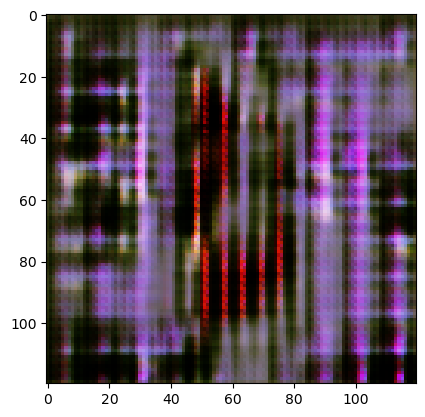

In [179]:
noise=  tf.random.normal([5, noise_shape],seed=randint(0,1000))
label = tf.Variable([10,5,2,1,7])

pred = gan(noise,label)
plt.imshow((pred[0, :, :, :]+1)/2.0)


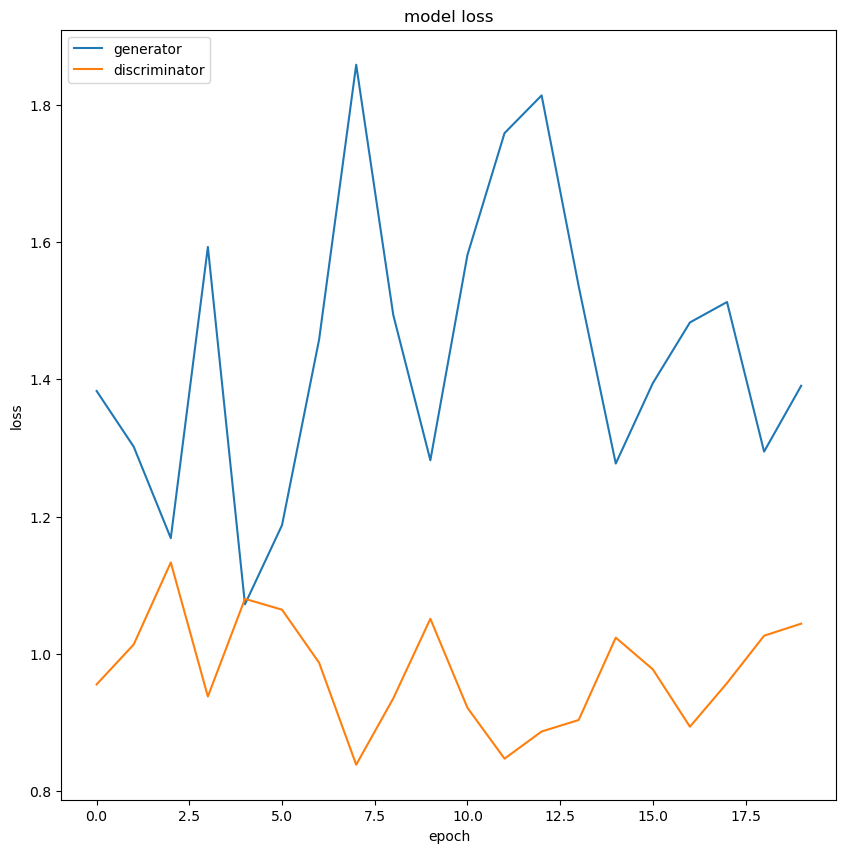

In [180]:
plt.figure(figsize=(10,10))
plt.plot(history.history['generator_loss'])
plt.plot(history.history['discriminator_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()